<a href="https://colab.research.google.com/github/ismailazdad/uwmgit/blob/main/cocoformat_dataset_creation_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook helps to create a dataset in the cocoformat and also has a visualization with with both coco and detectron API

Reference:
https://www.kaggle.com/code/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator/notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
# !rm -rf UW_Madison_segmentation

In [ ]:
!unzip /content/drive/MyDrive/UW_Madison_segmentation/train.zip -d /content/uw-madison-gi-tract-image-segmentation/

In [162]:
!unzip /content/drive/MyDrive/UW_Madison_segmentation/train.csv.zip -d /content/uw-madison-gi-tract-image-segmentation/

Archive:  /content/drive/MyDrive/UW_Madison_segmentation/train.csv.zip
replace /content/uw-madison-gi-tract-image-segmentation/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/uw-madison-gi-tract-image-segmentation/train.csv  


In [163]:
!mkdir working

In [164]:
!pwd

/content


In [165]:
import json
import numpy as np
import pycocotools.mask as mask_util
from skimage import measure
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2
import random
from itertools import groupby
import itertools
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob


In [166]:
# creating a dataframe
csv_path = os.path.abspath("/content/uw-madison-gi-tract-image-segmentation/train.csv")
df = pd.read_csv(csv_path)

df_with_mask = df[df['segmentation'].notnull()] # Removing the slices which donot have any segmnatation
df_with_mask = df_with_mask.reset_index(drop=True)

In [167]:
df_with_mask["segmentation"] = df_with_mask["segmentation"].astype("str")
df_with_mask["case_id"] = df_with_mask["id"].apply(lambda x: x.split("_")[0][4:])
df_with_mask["day_id"] = df_with_mask["id"].apply(lambda x: x.split("_")[1][3:])
df_with_mask["slice_id"] = df_with_mask["id"].apply(lambda x: x.split("_")[-1])

In [168]:
df_with_mask.sample(5)

id        class  \
20818   case143_day0_slice_0052      stomach   
4963   case118_day16_slice_0075  small_bowel   
33394   case74_day19_slice_0097  small_bowel   
23136  case141_day13_slice_0093  large_bowel   
1184   case129_day20_slice_0108  small_bowel   

                                                                                              segmentation  \
20818  30220 4 30484 9 30749 11 31015 11 31280 13 31545 14 31811 14 32076 14 32341 15 32607 15 32873 14...   
4963   14235 2 14491 6 14498 8 14511 3 14523 5 14756 27 14785 14 15021 46 15287 47 15552 49 15818 49 16...   
33394  26777 5 27041 8 27307 8 27519 3 27572 9 27783 7 27838 9 28049 7 28104 9 28314 9 28370 10 28580 1...   
23136  29149 4 29413 9 29628 5 29678 13 29891 9 29943 17 30155 12 30209 19 30420 14 30475 20 30685 15 3...   
1184   40454 4 40462 12 40811 29 41167 36 41523 42 41882 44 42239 48 42596 52 42954 54 43313 56 43379 7...   

      case_id day_id slice_id  
20818     143      0     0052  
4963      118     16     0075  
33394      74     19     0097  
23136     141     13     0093  
1184      129     20     0108

In [169]:
def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob(f"{folder}/{file_starter}*")
    # returning the first file, though it will always hold one file.
    return file[0]
dataset_path = os.path.abspath("/content/uw-madison-gi-tract-image-segmentation/")    
df_with_mask["path"] = df_with_mask["id"].apply(lambda x: fetch_file_from_id(dataset_path, x))
df_with_mask.head()

id    class  \
0  case123_day20_slice_0065  stomach   
1  case123_day20_slice_0066  stomach   
2  case123_day20_slice_0067  stomach   
3  case123_day20_slice_0068  stomach   
4  case123_day20_slice_0069  stomach   

                                                                                          segmentation  \
0  28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 ...   
1  27561 8 27825 11 28090 13 28355 14 28620 15 28886 15 29151 17 29417 17 29682 18 29948 18 30214 1...   
2  15323 4 15587 8 15852 10 16117 11 16383 12 16649 12 16915 12 17181 12 17447 12 17713 12 17979 12...   
3  14792 5 15056 9 15321 11 15587 11 15852 13 16118 13 16383 15 16649 15 16915 15 17180 16 17446 16...   
4  14526 6 14789 12 15054 14 15319 16 15584 17 15850 18 16115 19 16381 19 16646 20 16912 20 17178 2...   

  case_id day_id slice_id  \
0     123     20     0065   
1     123     20     0066   
2     123     20     0067   
3     123     20     0068   
4     123     20     0069   

                                                                                                  path  
0  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0065_266_266_1...  
1  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0066_266_266_1...  
2  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0067_266_266_1...  
3  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0068_266_266_1...  
4  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0069_266_266_1...

In [172]:
pd.options.display.max_colwidth = 200
df_with_mask.path.head(1)[0]

'/content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png'

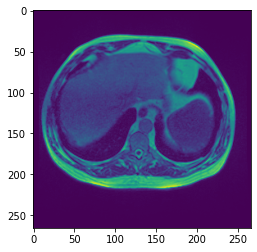

In [177]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(df_with_mask.path[0])
imgplot = plt.imshow(img)
plt.show()

In [179]:
pd.options.display.max_colwidth = 100
df_with_mask["height"] = df_with_mask["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
df_with_mask["width"] = df_with_mask["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")
df_with_mask['size'] =df_with_mask['height'].astype(str) +'x'+ df_with_mask['width'].astype(str)
df_with_mask.head()

id    class  \
0  case123_day20_slice_0065  stomach   
1  case123_day20_slice_0066  stomach   
2  case123_day20_slice_0067  stomach   
3  case123_day20_slice_0068  stomach   
4  case123_day20_slice_0069  stomach   

                                                                                          segmentation  \
0  28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 ...   
1  27561 8 27825 11 28090 13 28355 14 28620 15 28886 15 29151 17 29417 17 29682 18 29948 18 30214 1...   
2  15323 4 15587 8 15852 10 16117 11 16383 12 16649 12 16915 12 17181 12 17447 12 17713 12 17979 12...   
3  14792 5 15056 9 15321 11 15587 11 15852 13 16118 13 16383 15 16649 15 16915 15 17180 16 17446 16...   
4  14526 6 14789 12 15054 14 15319 16 15584 17 15850 18 16115 19 16381 19 16646 20 16912 20 17178 2...   

  case_id day_id slice_id  \
0     123     20     0065   
1     123     20     0066   
2     123     20     0067   
3     123     20     0068   
4     123     20     0069   

                                                                                                  path  \
0  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0065_266_266_1...   
1  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0066_266_266_1...   
2  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0067_266_266_1...   
3  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0068_266_266_1...   
4  /content/uw-madison-gi-tract-image-segmentation/case123/case123_day20/scans/slice_0069_266_266_1...   

   height  width     size  
0     266    266  266x266  
1     266    266  266x266  
2     266    266  266x266  
3     266    266  266x266  
4     266    266  266x266

In [180]:
df_with_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
 3   case_id       33913 non-null  object
 4   day_id        33913 non-null  object
 5   slice_id      33913 non-null  object
 6   path          33913 non-null  object
 7   height        33913 non-null  int64 
 8   width         33913 non-null  int64 
 9   size          33913 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.6+ MB


In [181]:
df_with_mask['size'].value_counts()

266x266    22328
360x310     9911
276x276     1557
234x234      117
Name: size, dtype: int64

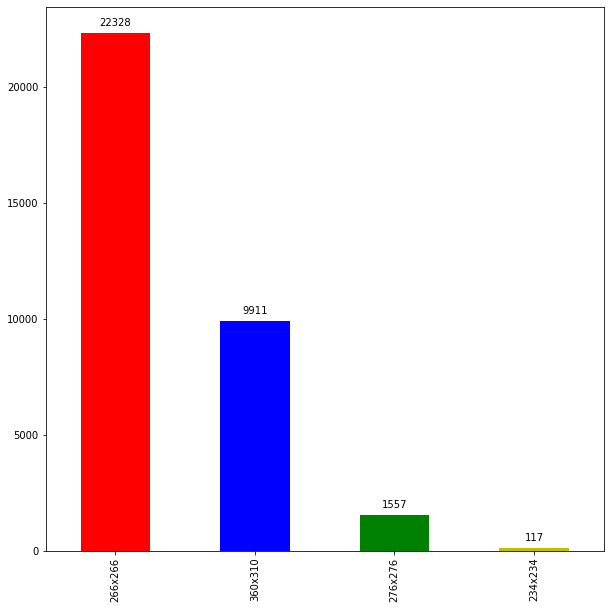

In [182]:
fig = plt.figure(figsize=(10, 10))
ax = df_with_mask['size'].value_counts().plot(kind='bar', color=['r','b','g','y']) 

for p in ax.patches:
    ax.annotate(s=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.show()

In [183]:
df[df['segmentation'].isnull()].shape

(81575, 3)

In [184]:
df[df['segmentation'].notnull()].shape

(33913, 3)

In [185]:
df_with_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
 3   case_id       33913 non-null  object
 4   day_id        33913 non-null  object
 5   slice_id      33913 non-null  object
 6   path          33913 non-null  object
 7   height        33913 non-null  int64 
 8   width         33913 non-null  int64 
 9   size          33913 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.6+ MB


In [186]:
df_with_mask['class'].value_counts()

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64

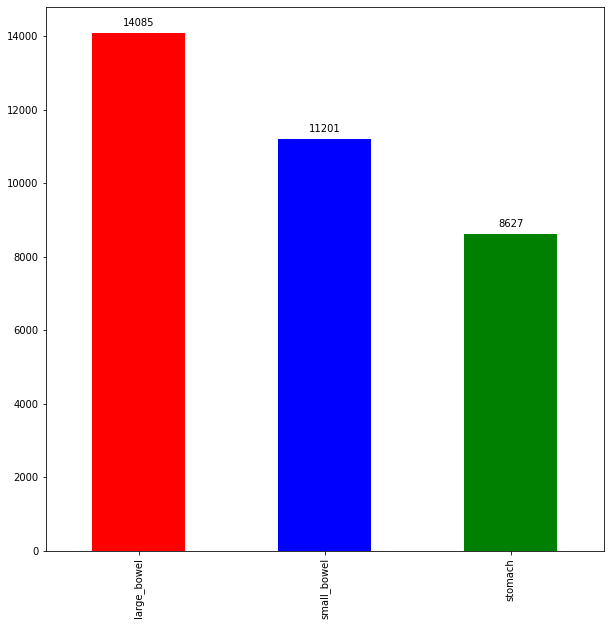

In [187]:
fig = plt.figure(figsize=(10, 10))
ax = df_with_mask['class'].value_counts().plot(kind='bar', color=['r','b','g']) 

for p in ax.patches:
    ax.annotate(s=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.show()

In [208]:
df_with_mask.to_csv('/content/drive/MyDrive/UW_Madison_segmentation/madison.csv')

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
! pip install pycocotools
! pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [192]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def create_coco_format_json(data_frame, classes, filepaths):
    images = []
    annotations = []
    categories = []
    count = 0
    
    # Additing categories
    for idx, class_ in enumerate(classes):
        categories.append(
            { 
                "id": idx,
                "name": class_
            }
        )

    for filepath in tqdm(filepaths):
        file_id = ('_'.join((filepath.split("/")[-3] + "_" + filepath.split("/")[-1]).split("_")[:-4]))
        height_slice = int(filepath.split("/")[-1].split("_")[3])
        width_slice = int(filepath.split("/")[-1].split("_")[2])
        ids = data_frame.index[data_frame['id'] == file_id].tolist()
        # file_name = '/'.join(filepath.split("/")[2:])
        file_name = '/'.join(filepath.split("/")[3:])
        # print('/'.join(filepath.split("/")[2:]))
        if (len(ids) > 0):
            # Adding images which has annotations
            images.append(
                {
                    "id":file_id,
                    "width":width_slice,
                    "height":height_slice,
                    "file_name": file_name
                }
            )
            for idx in ids:
                mk = rle_decode(data_frame.iloc[idx]['segmentation'], (height_slice, width_slice))
                ys, xs = np.where(mk)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)              
                contours,hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
                for id_, contour in enumerate(contours):
                    mask_image = np.zeros((mk.shape[0], mk.shape[1], 3),  np.uint8)
                    cv2.drawContours(mask_image, [contour], -1, (255,255,255), thickness=cv2.FILLED)
                    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                    mask_image_bool = np.array(mask_image, dtype=bool).astype(np.uint8)
                    ys, xs = np.where(mask_image_bool)
                    x1, x2 = min(xs), max(xs)
                    y1, y2 = min(ys), max(ys)
                    enc =binary_mask_to_rle(mask_image_bool)
                    seg = {
                        'segmentation':enc, 
                        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                        'area': int(np.sum(mask_image_bool)),
                        'image_id':file_id, 
                        'category_id':classes.index(data_frame.iloc[idx]['class']), 
                        'iscrowd':0, 
                        'id': count
                    }
                    annotations.append(seg)
                    count +=1
            
    # creating the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }
    
    return dataset_coco_format

In [194]:
# dataset_path = os.path.abspath("/kaggle/input/uw-madison-gi-tract-image-segmentation/")
# output_path = os.path.abspath("/kaggle/working/")
# csv_path = os.path.abspath("/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv")



# Creation of train test split
train_df, test_df = train_test_split(df_with_mask, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(train_df.head())
print("\n \nNumber of Train Images:{}".format(len(train_df)))
print("Number of Test Images:{}".format(len(test_df)))


 
Number of Train Images:27130
Number of Test Images:6783


In [195]:
df_with_mask['class'].unique()

array(['stomach', 'large_bowel', 'small_bowel'], dtype=object)

In [196]:
classes = ['small_bowel', 'large_bowel', 'stomach']

filepaths = list()
for (dirpath, dirnames, filenames) in os.walk(dataset_path):
    filepaths += [os.path.join(dirpath, file) for file in filenames if file.endswith(".png")]
    
train_json = create_coco_format_json(train_df, classes, filepaths)
test_json = create_coco_format_json(test_df, classes, filepaths)

100%|██████████| 38496/38496 [02:08<00:00, 300.70it/s]


In [197]:
test_json

{'annotations': [{'area': 2095,
   'bbox': [156, 61, 33, 79],
   'category_id': 2,
   'id': 0,
   'image_id': 'case84_day23_slice_0072',
   'iscrowd': 0,
   'segmentation': {'counts': [41616,
     9,
     216,
     8,
     10,
     37,
     205,
     63,
     200,
     67,
     196,
     71,
     193,
     74,
     191,
     75,
     190,
     77,
     189,
     77,
     188,
     78,
     188,
     78,
     187,
     79,
     187,
     79,
     187,
     79,
     187,
     79,
     187,
     78,
     188,
     78,
     188,
     77,
     190,
     75,
     191,
     73,
     193,
     71,
     196,
     68,
     199,
     65,
     202,
     64,
     203,
     62,
     206,
     59,
     209,
     56,
     212,
     53,
     215,
     50,
     218,
     46,
     224,
     39,
     231,
     33,
     244,
     18,
     20635],
    'size': [266, 266]}},
  {'area': 1480,
   'bbox': [118, 29, 44, 47],
   'category_id': 2,
   'id': 1,
   'image_id': 'case84_day23_slice_0072',
   'iscrowd': 

# Saving the train and test json

In [201]:
# Code taken from: https://stackoverflow.com/a/65151218/12890869
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()
    
with open('working/train_json.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4, default=np_encoder)
    
with open('working/test_json.json', 'w', encoding='utf-8') as f:
    json.dump(test_json, f, ensure_ascii=True, indent=4, default=np_encoder)

In [202]:
!cp /content/working/test_json.json /content/drive/MyDrive//UW_Madison_segmentation/test_json.json

In [203]:
!cp /content/working/train_json.json /content/drive/MyDrive//UW_Madison_segmentation/train_json.json

# Visualization with Detectron2

In [204]:
from pathlib import Path
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

output_path = os.path.abspath("/content/working/")
Data_Resister_training="train";
Data_Resister_testing="test";

if Data_Resister_training in DatasetCatalog.list():
    DatasetCatalog.remove(Data_Resister_training)
if Data_Resister_testing in DatasetCatalog.list():
    DatasetCatalog.remove(Data_Resister_testing)

register_coco_instances(
    Data_Resister_training,
    {}, 
    os.path.join(output_path, "train_json.json"), 
    dataset_path)

register_coco_instances(
    Data_Resister_testing,
    {}, 
    os.path.join(output_path, "test_json.json"), 
    dataset_path)

metadata = MetadataCatalog.get(Data_Resister_training)
metadata = MetadataCatalog.get(Data_Resister_testing)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_test = DatasetCatalog.get(Data_Resister_testing)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [205]:
dataset_test

[{'annotations': [{'bbox': [178, 117, 27, 31],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 2,
    'iscrowd': 0,
    'segmentation': {'counts': b'a[^16R84M3N2M4M3L2O1N2O1N100O2O01O000O2O1O0O2N2N2N1O2M3M4LUg?',
     'size': [266, 266]}}],
  'file_name': '/content/uw-madison-gi-tract-image-segmentation/case101/case101_day20/scans/slice_0067_266_266_1.50_1.50.png',
  'height': 266,
  'image_id': 'case101_day20_slice_0067',
  'width': 266},
 {'annotations': [{'bbox': [176, 114, 34, 35],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 2,
    'iscrowd': 0,
    'segmentation': {'counts': b'mj]13U84M2N3N2N4K5L2N1N2N2O1N1O1O100O1001O001O001N2N1O2N1O2M3N1N3N2N3M4Jc]>',
     'size': [266, 266]}}],
  'file_name': '/content/uw-madison-gi-tract-image-segmentation/case101/case101_day20/scans/slice_0068_266_266_1.50_1.50.png',
  'height': 266,
  'image_id': 'case101_day20_slice_0068',
  'width': 266},
 {'annotations': [{'bbox': [163, 99, 56, 54],
    'bbox_mode': <BoxMode.XYWH

/content/uw-madison-gi-tract-image-segmentation/case85/case85_day29/scans/slice_0086_360_310_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case47/case47_day0/scans/slice_0092_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case19/case19_day0/scans/slice_0112_360_310_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case41/case41_day0/scans/slice_0082_360_310_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case2/case2_day3/scans/slice_0059_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case143/case143_day18/scans/slice_0029_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case143/case143_day18/scans/slice_0055_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case81/case81_day0/scans/slice_0098_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case125/case125_day15/scans/slice_0102_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-seg

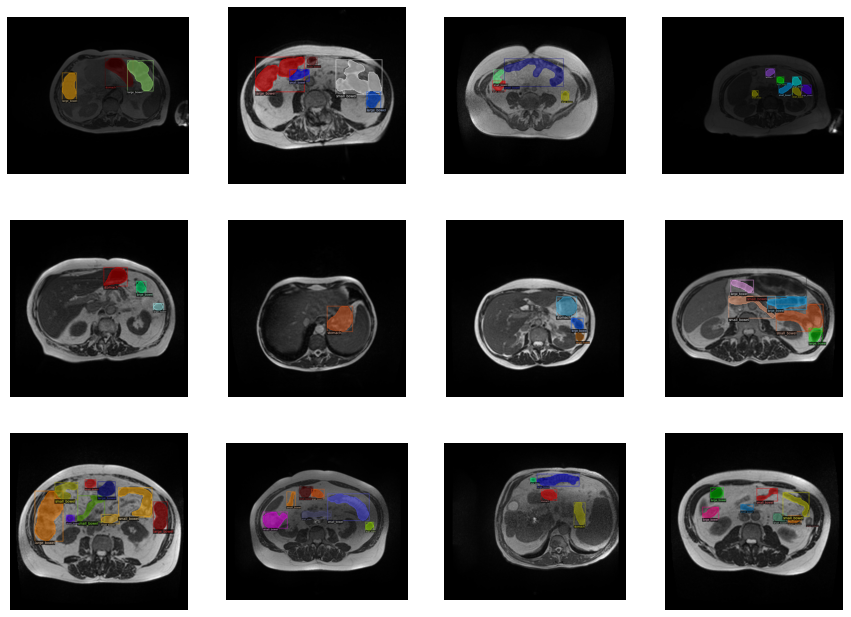

In [206]:
plt.figure(figsize=(15,15))
for i, idx in enumerate(random.sample(range(0, len(dataset_train)), 12)):
    d=dataset_train[idx]
    print(d["file_name"])
    gray_image = cv2.imread(d["file_name"], cv2.IMREAD_ANYDEPTH)
    gray_image = gray_image / gray_image.max()
    img = np.repeat(gray_image[..., np.newaxis], 3, -1) * 255.0
    v = Visualizer(img,
                    metadata=metadata, 
                    scale=2,
                    instance_mode=ColorMode.IMAGE_BW
        )
    out = v.draw_dataset_dict(d)
    plt.subplot(4, 4, i+1)
    plt.imshow(out.get_image())
    plt.axis('off')
plt.show()